# Dummy variable (no pooling) model for housing prices

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha_{NH[j]} + \beta * log(LA)_i \\
\alpha_j\sim Normal(1, 0.5),\space for\space j = 1...J\space neighbourhoods\\
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

In [57]:
import math
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Train/Test data
train = pd.read_csv('../../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
#train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()
train['log_sales_price_std'] = (train[['log_sales_price']] - train[['log_sales_price']].mean()) / train[['log_sales_price']].std()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
#test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

## Load and simulate fake data

In [58]:
no_pooling_model = pystan.StanModel(file = '../../models/dummy_variable_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_45496414bda3f7b949af026c548db4c4 NOW.


In [59]:
# Set parameters
alpha_sd = 1
beta_sd = 1
sigma_sd = 1

In [60]:
npm_data_check = dict(N = len(train),
              log_sales_price = train['log_sales_price_std'],
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = alpha_sd, 
              beta_sd = beta_sd, 
              sigma_sd = sigma_sd,
              run_estimation = 0)

fit_npm_check = no_pooling_model.sampling(data=npm_data_check)
npm_df_check = fit_npm_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Traceplots

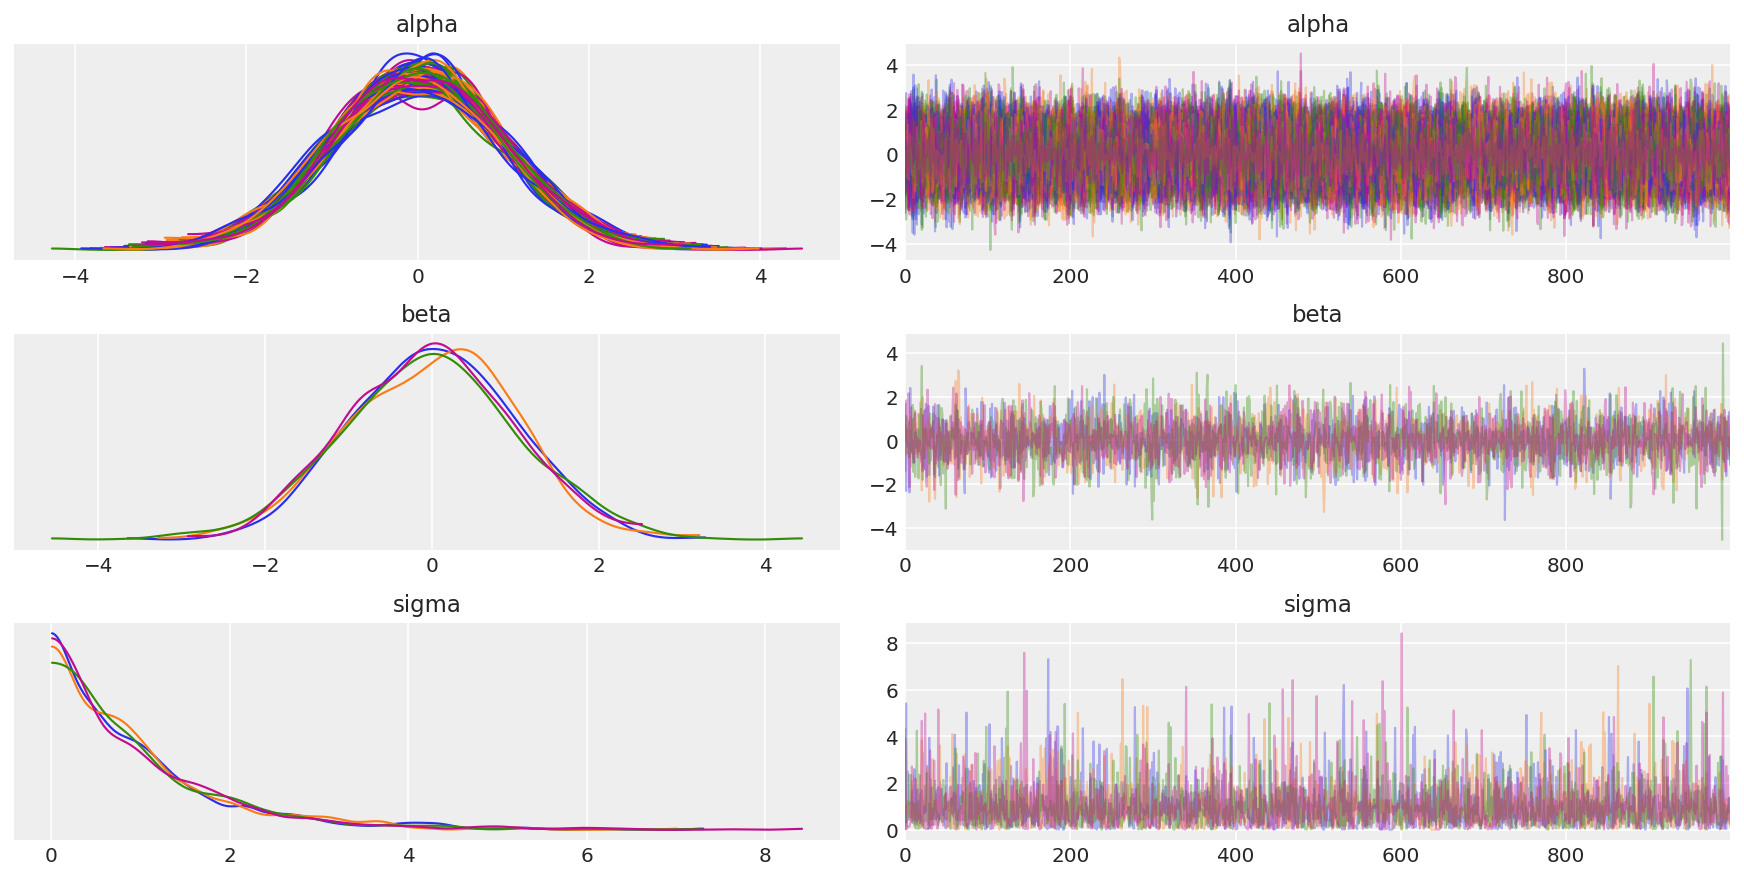

In [61]:
# Inspect model fit
az.plot_trace(fit_npm_check, 
              var_names=["alpha", "beta", "sigma"], 
              compact = True, 
              chain_prop = 'color');

## Prior Predictive Checks

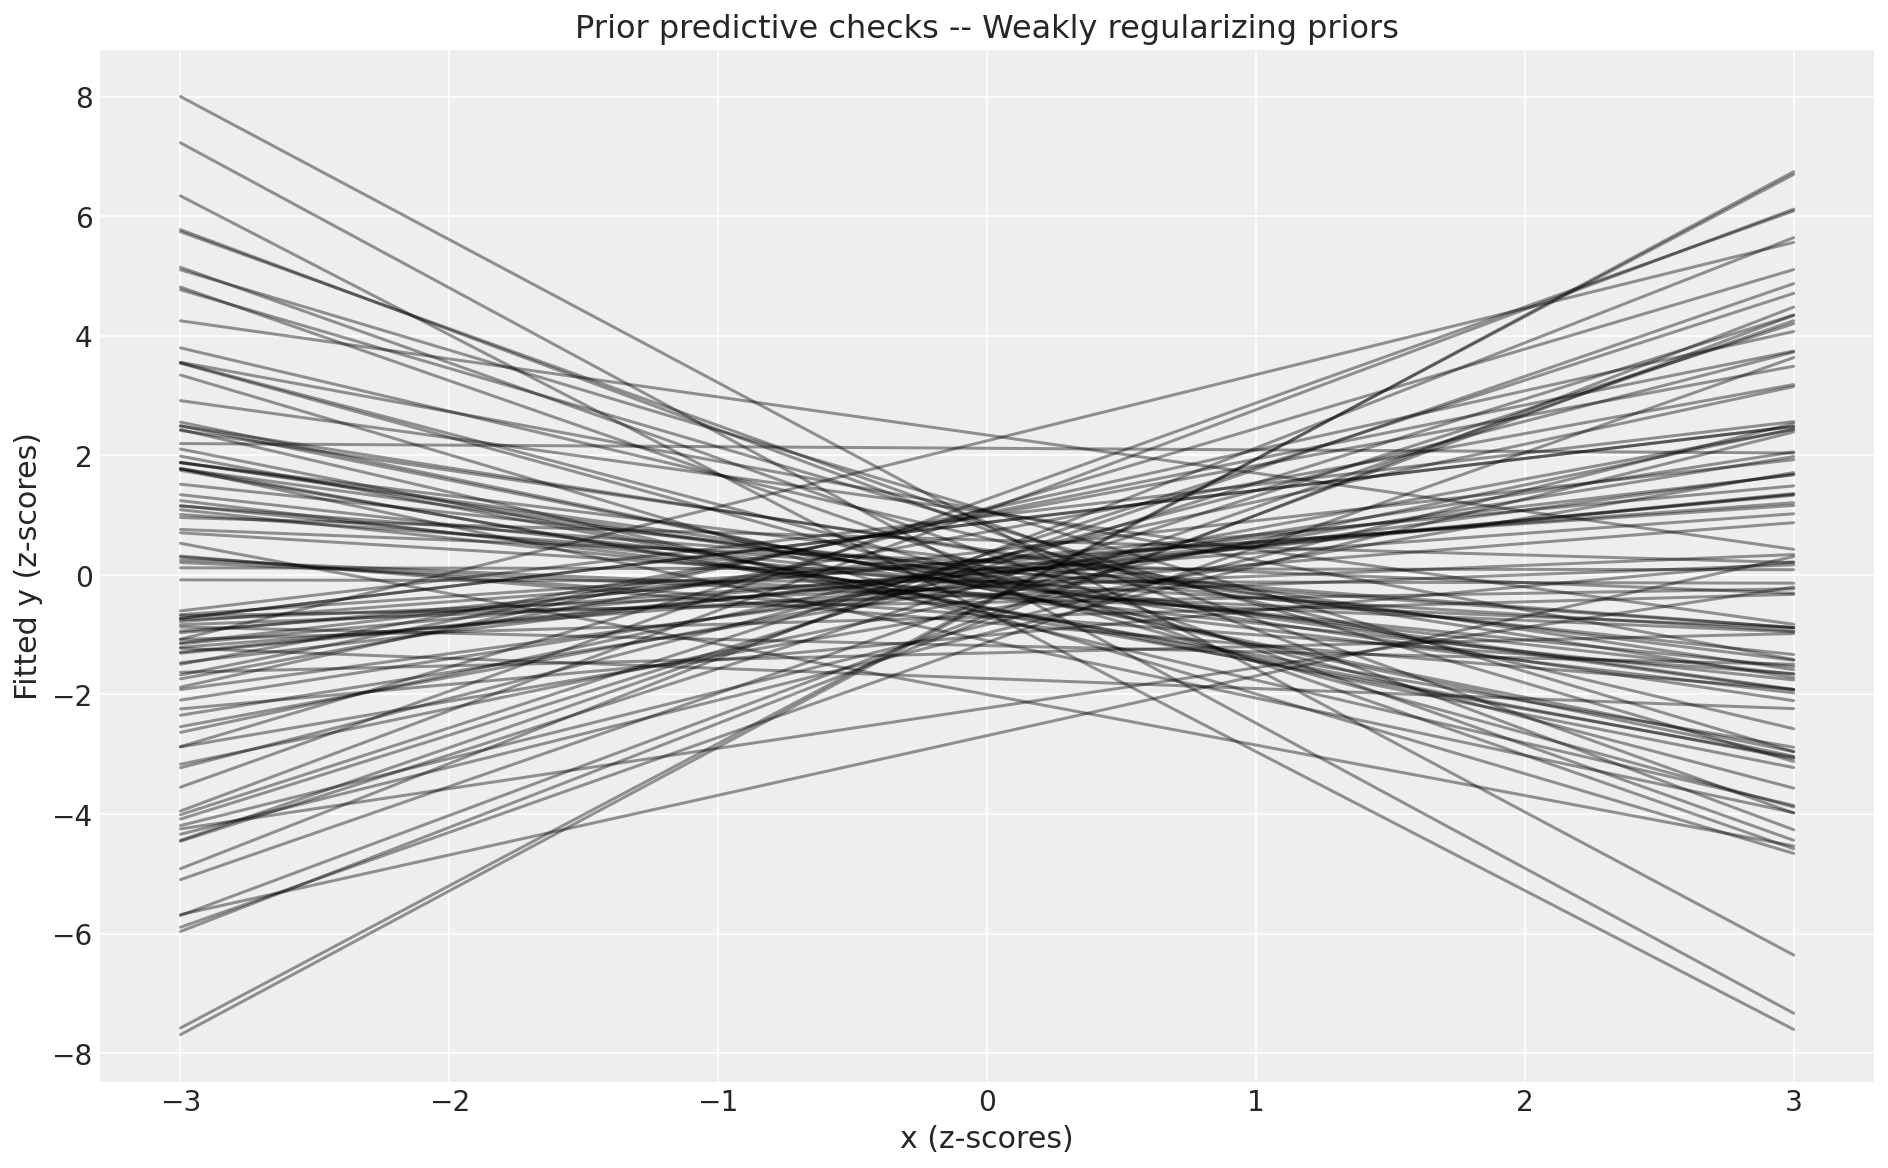

In [74]:
_, ax = plt.subplots(figsize = (13, 8))

x = np.linspace(-3, 3, 200)

for alpha, beta in zip(npm_df_check["alpha[4]"][:100], npm_df_check["beta"][:100]):
    y = alpha + beta * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("x (z-scores)")
ax.set_ylabel("Fitted y (z-scores)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

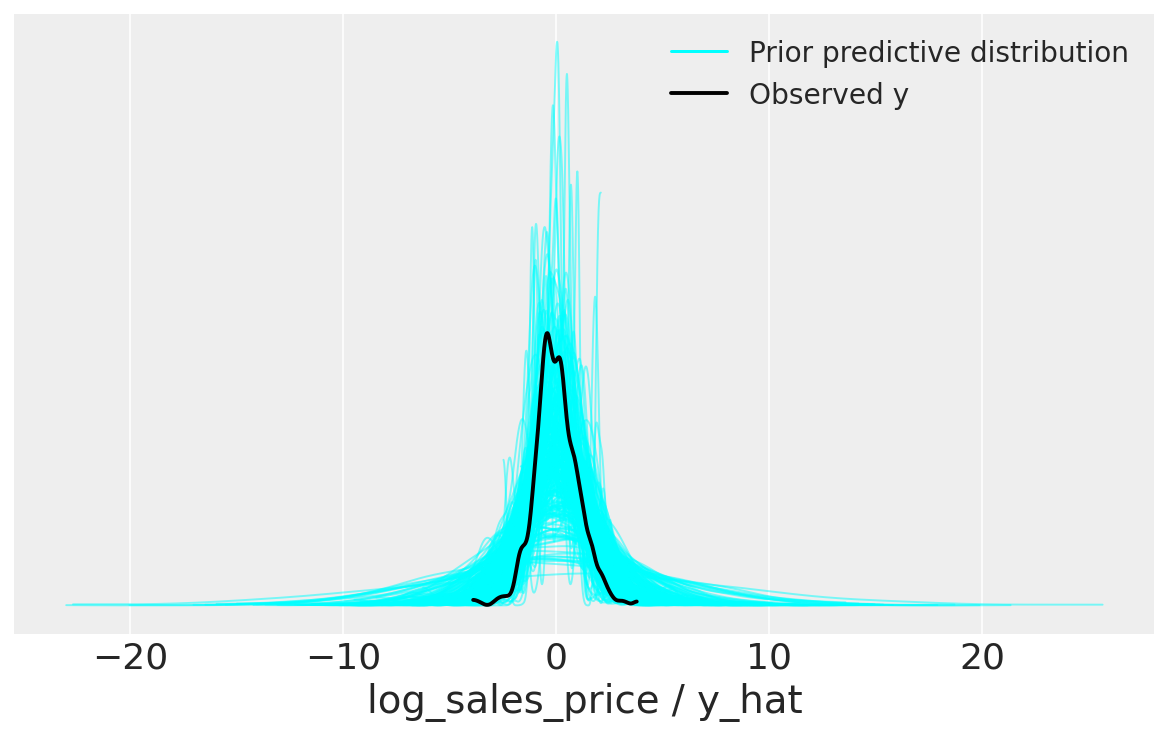

In [63]:
npm_check_az = az.from_pystan(
    posterior=fit_npm_check,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

# Visualise prior predictive checks
az.plot_ppc(data = npm_check_az, 
            kind = 'kde', 
            data_pairs = {'log_sales_price' : 'y_hat'},
            legend = False,
            color='cyan',
            mean = False,
            figsize=(8, 5),
            alpha = 0.5,
            num_pp_samples=300)

#plt.xlim(0, 2)
plt.legend(['Prior predictive distribution', 'Observed y']);

<AxesSubplot:ylabel='Density'>

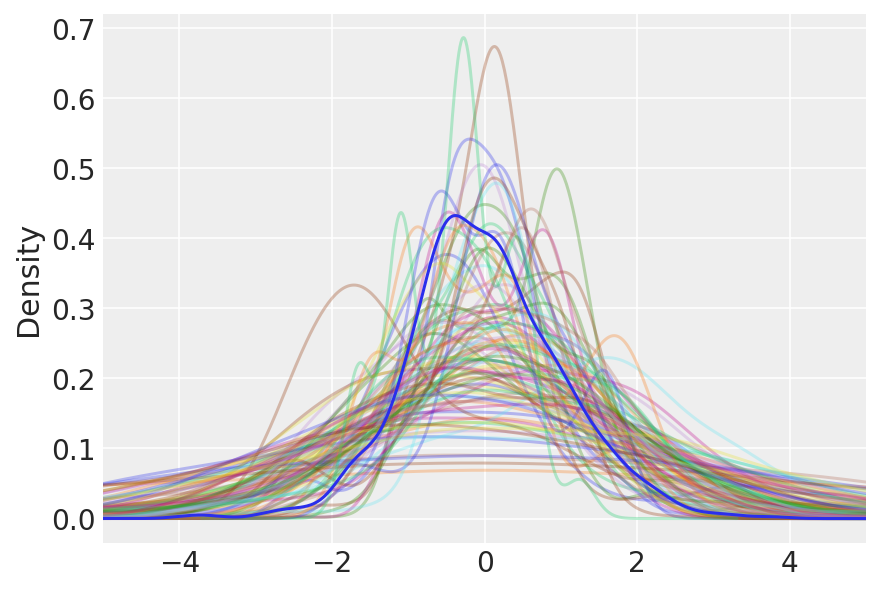

In [64]:
fig, axes = plt.subplots(1,1)

npm_df_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-5, 5),
                                                        ax = axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes)

#plt.vlines(x=train['log_sales_price_std'].min(), ymin=0, ymax=13,color='black', linestyles='dashed')
#plt.vlines(x=train['log_sales_price_std'].max(), ymin=0, ymax=13,color='black', linestyles='dashed');

## Fit model on fake data and recapture known parameters (appendix?)

In [65]:
random_draw = 50
y_sim = npm_df_check.filter(regex = 'y_hat').iloc[random_draw, :]
true_parameters = npm_df_check.filter(regex = 'alpha|beta|sigma').iloc[random_draw, :]

_npm_data_check = dict(N = len(train),
              log_sales_price = y_sim,
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = alpha_sd, 
              beta_sd = beta_sd,
              sigma_sd = sigma_sd, 
              run_estimation = 1)

_fit_npm_check = no_pooling_model.sampling(data=_npm_data_check)
_npm_df_check = _fit_npm_check.to_dataframe()
fake_fit = _npm_df_check.filter(regex = 'alpha|beta|sigma')
parameter_df = pd.melt(fake_fit)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


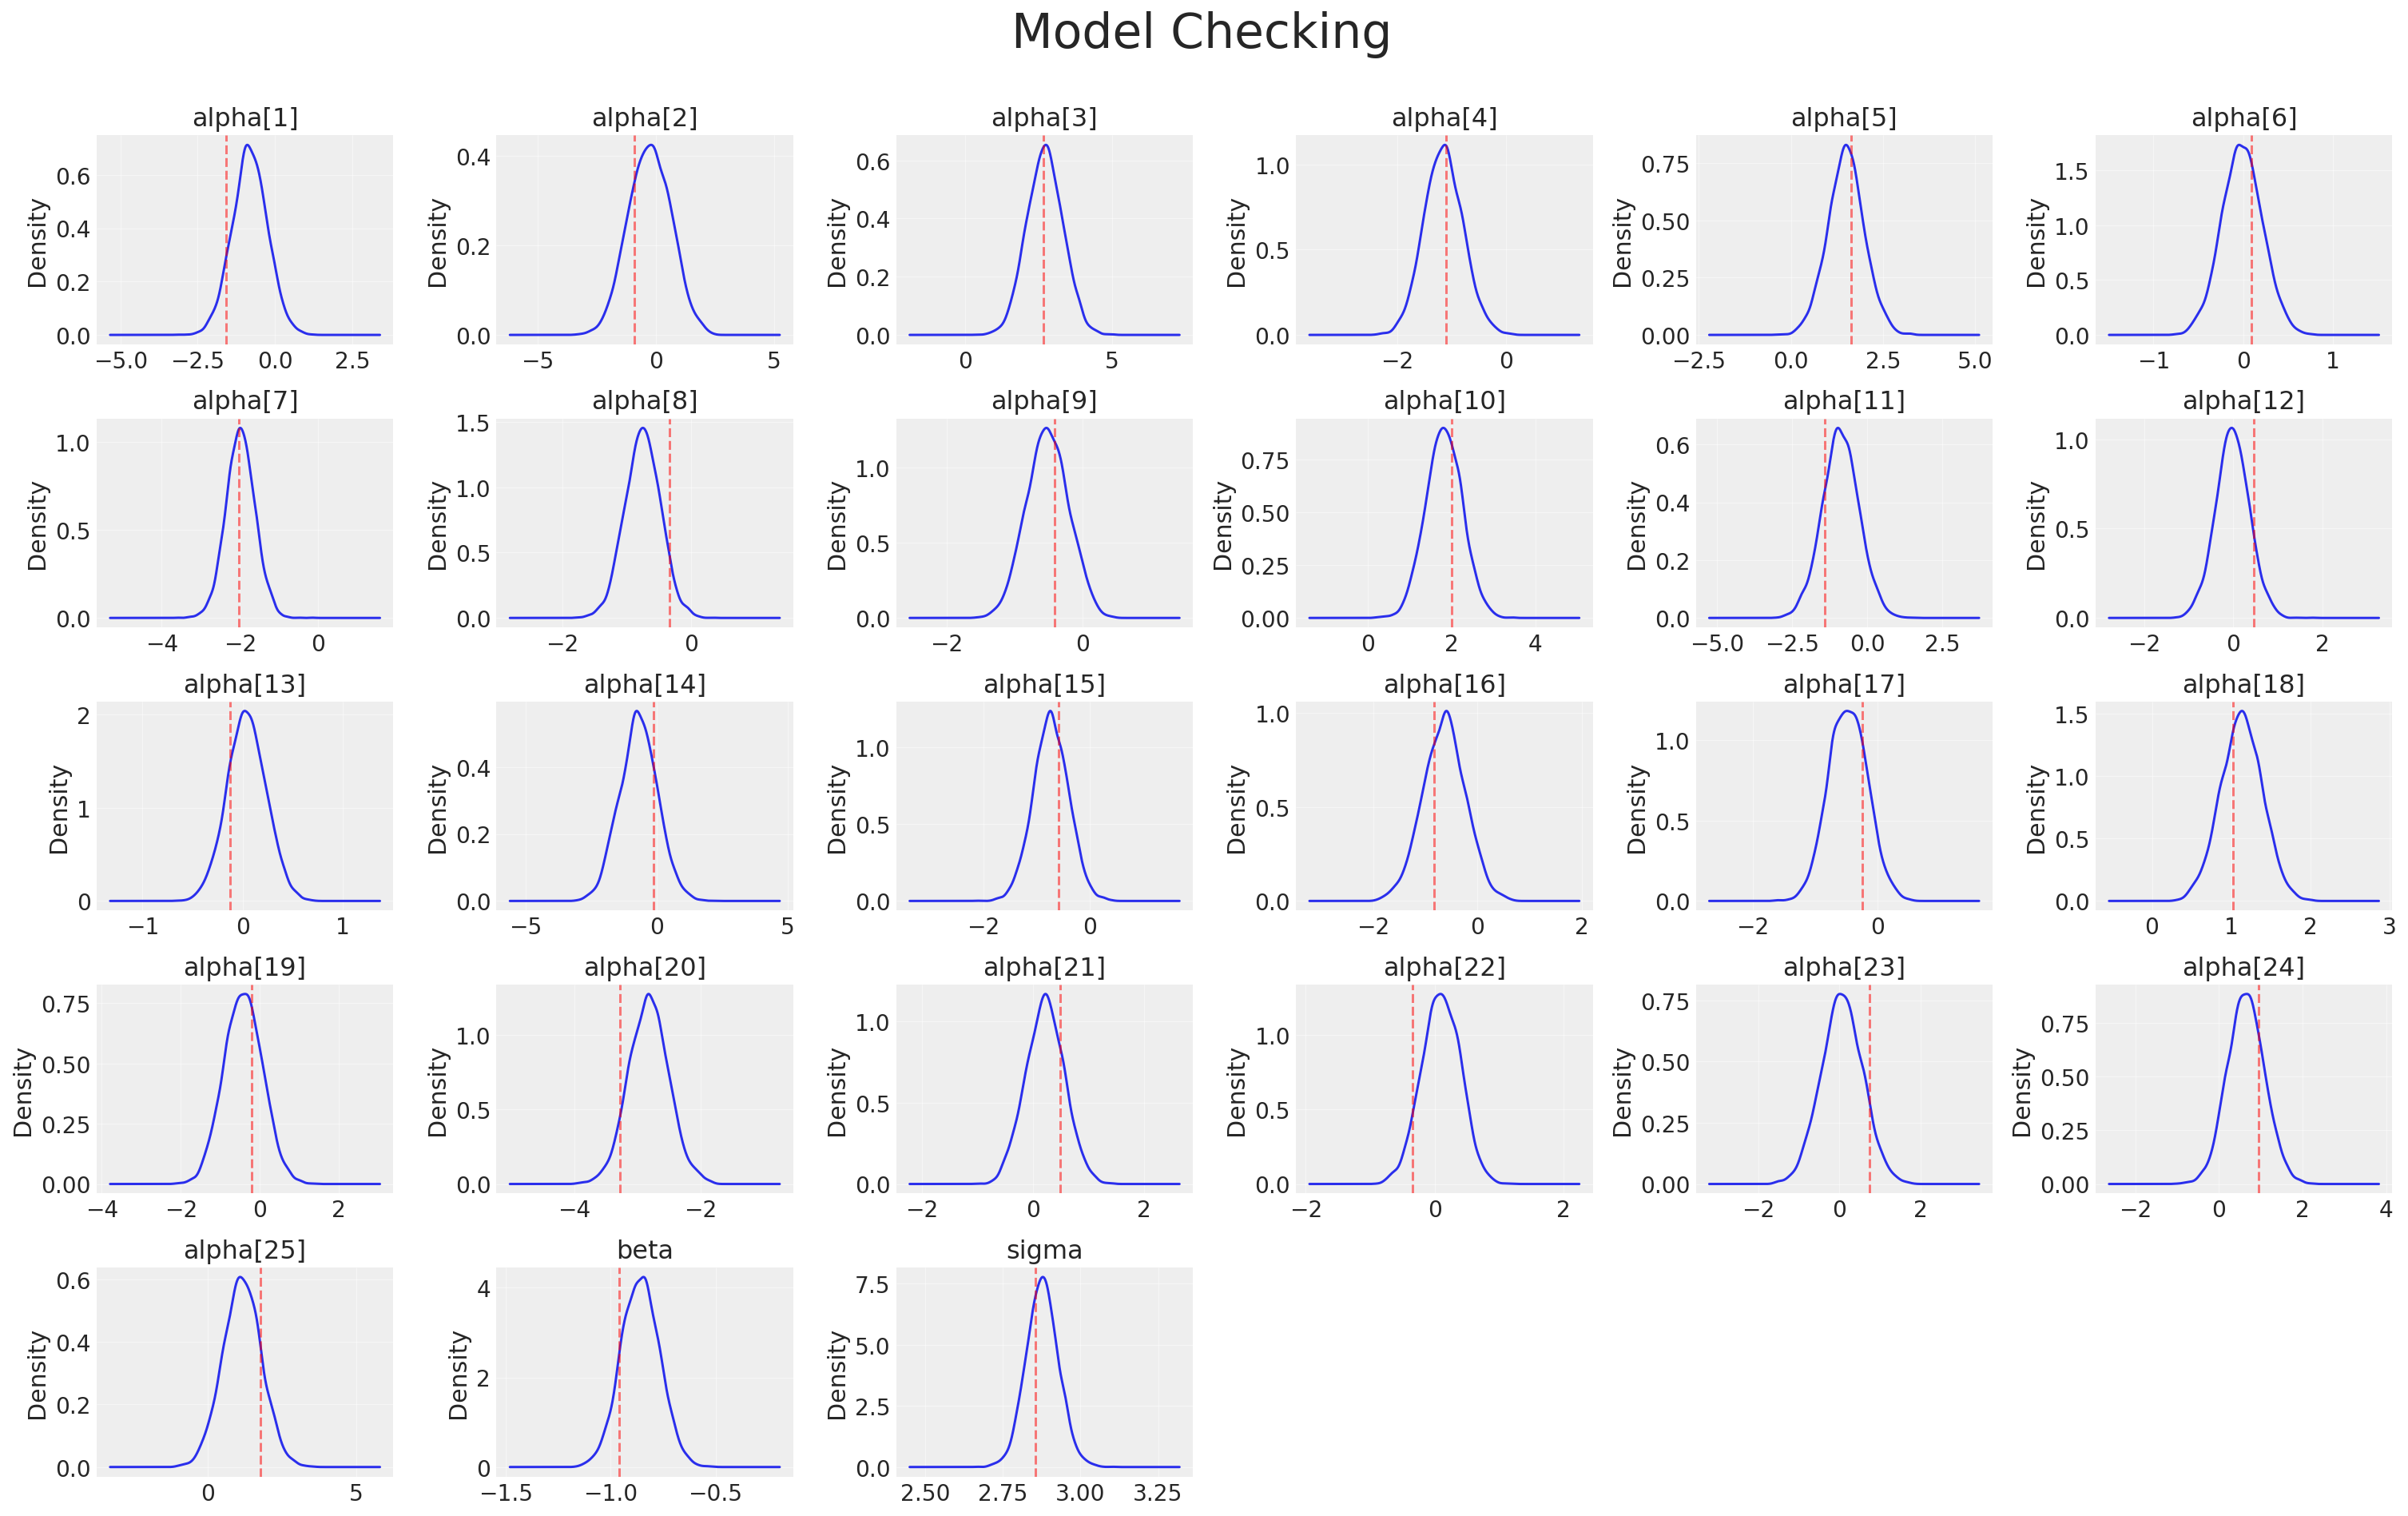

In [66]:
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking', y = 1.01, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df[['variable']].drop_duplicates().set_index('variable').index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

In [67]:
npm_data = dict(N = len(train),
              log_sales_price = train['log_sales_price_std'],
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = alpha_sd, 
              beta_sd = beta_sd, 
              sigma_sd = sigma_sd,
              run_estimation = 1)

fit_npm = no_pooling_model.sampling(data=npm_data)
fit_npm_df = fit_npm.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


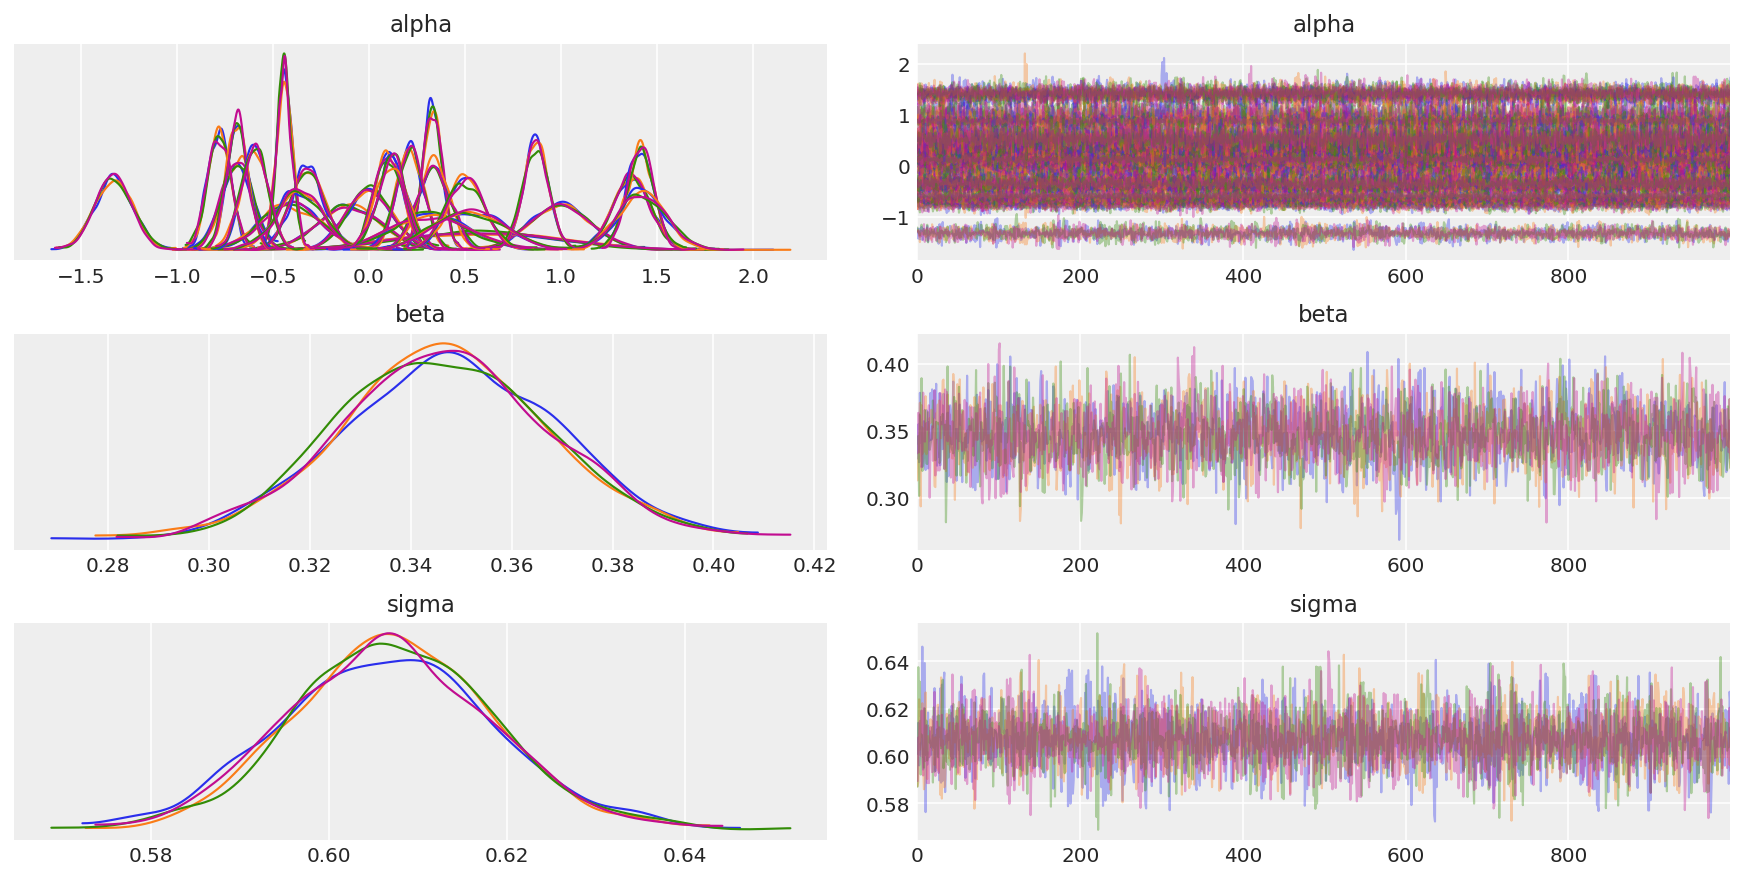

In [68]:
# Inspect model fit
az.plot_trace(fit_npm, 
              var_names=["alpha", "beta", "sigma"], 
              compact = True, 
              chain_prop = 'color');

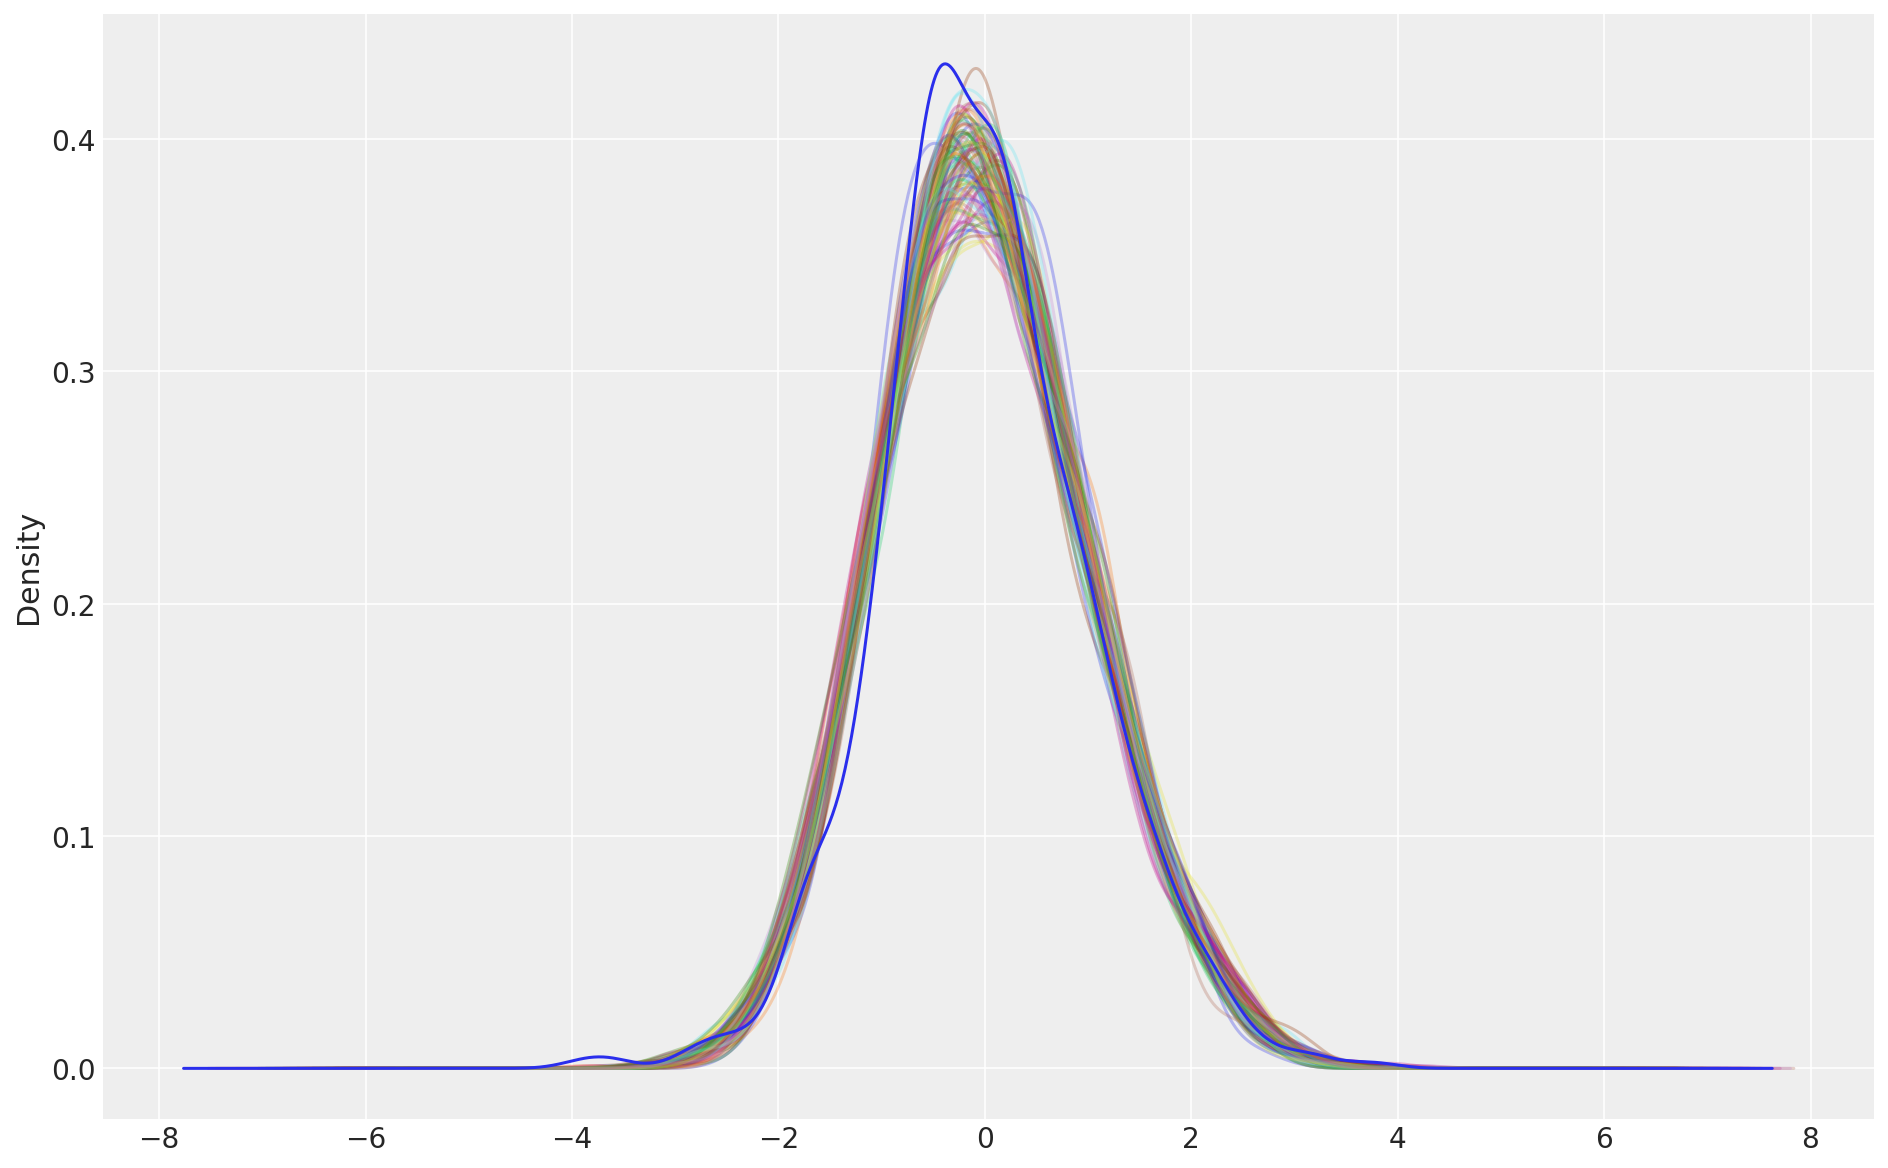

In [69]:
fig, axes = plt.subplots(1,1, figsize = (13, 8))

fit_npm_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False,
                                                               ax=axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

<AxesSubplot:xlabel='log_sales_price / y_hat'>

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


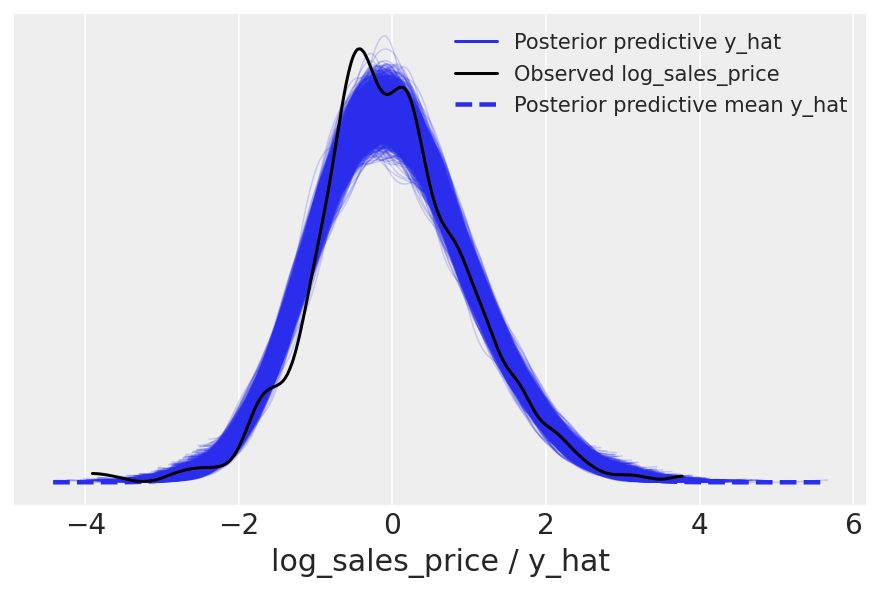

In [70]:
npm_az = az.from_pystan(
    posterior=fit_npm,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)


az.plot_ppc(data = npm_az, kind = 'kde', data_pairs = {'log_sales_price' : 'y_hat'})

In [71]:
az.loo(npm_az, pointwise = True, scale = 'log')

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/stats.py:932: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 1460 log-likelihood matrix

         Estimate       SE
elpd_loo -6917752.15  91328.69
p_loo    2309811.86        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad) 1460  100.0%

In [72]:
predictions = pd.DataFrame(np.exp(fit_npm_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].std()+train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

no_pooling_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

no_pooling_csv.to_csv('../../data/submissions/dummy_no_pooling.csv', index = False)


In [73]:
%%sh
cd ../../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f dummy_no_pooling.csv -m "Dummy variable (no pooling) model"


Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:07<00:00, 4.75kB/s]
